In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('dark')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score,\
precision_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
# from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler, RobustScaler

Detail dari dataset hari ini bisa dibaca di:  
https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists?select=aug_train.csv  

Buatlah EDA mengenai demografis calon karyawan dan hubungannya dengan kemungkinan mereka bekerja di perusahaan yg menyediakan training!  

Setelah selasai, upload hasil analisis kalian ke Github kalian masing-masing dan kirimkan link github kalian ke brigita.gems@gmail.com untuk feedback.

In [5]:
df = pd.read_csv('hr-analytic.csv')

In [6]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [7]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

### Analisa City

In [102]:
df['city'].value_counts()[:10] / df['city'].value_counts().sum() * 100

city_103    22.732018
city_21     14.103769
city_16      8.001879
city_114     6.973588
city_160     4.410690
city_136     3.058774
city_67      2.249713
city_75      1.592024
city_102     1.586804
city_104     1.571145
Name: city, dtype: float64

- Top 5 city dari kandidat-nya adalah city_103, city_21, city_16, city_114 dan city_160. Dengan yang terbesar adalah city_103 di persentase 22%. Maka dari itu, perusahaan dapat memberi perhatian lebih terhadap kota tersebut. 

In [107]:
df[df['target'] == 1.0]['city'].value_counts().sort_values(ascending=False)[:10]

city_21     1597
city_103     928
city_160     199
city_16      179
city_11      147
city_114     133
city_73       74
city_100      65
city_90       62
city_136      61
Name: city, dtype: int64

- Dari top 5 city tersebut, yang paling banyak mencari pekerjaan adalah city_21, city_103, city_160, city_16 dan city_11.


- Dapat dilihat bahwa city_11, masuk top 5 untuk kandidat yang mencari pekerjaan terbanyak, namun, city_11 tidak masuk di top 5 maupun top 10 persentase terbanyak dari total kandidat.


- Maka dari itu, perusahaan harus hati-hati jika tempat menjadi patokkan untuk mencari orang-orang yang mencari pekerjaan karena orang-orang yang mencari pekerjaan bisa datang bukan dari kota mayoritas kandidat.

### Analisa City Development Index

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


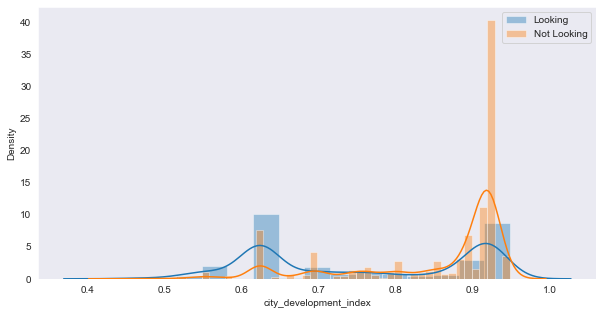

In [108]:
plt.figure(figsize=(10, 5))
sns.distplot(df[df['target'] == 1.0]['city_development_index'], label='Looking')
sns.distplot(df[df['target'] == 0.0]['city_development_index'], label='Not Looking')
plt.legend()

- Kandidat yang sedang mencari pekerjaan banyak yang datang dari yang city_development index-nya sekitar 0.6 - 0.65 dan 0.9 - 0.95


- Untuk yang city_development_index-nya di tengah-tengah value tersebut, mereka cenderung untuk tidak mencari pekerjaan. 


- Agar optimal, perusahaan harus melihat ke kota-kota yang city_development index-nya cenderung tinggi (di atas 0.9) dan di tengah-tengah (sekitar 0.6 - 0.7)

### Analisa Gender

In [110]:
df['gender'].value_counts()[:10] / df['gender'].value_counts()[:10].sum() * 100

Male      90.245734
Female     8.450512
Other      1.303754
Name: gender, dtype: float64

- 90% dari data adalah laki-laki, terlihat kecendurungan data imbalance terjadi ketika menyebarkan survei-nya, atau mungkin di area tersebut 90% populasi adalah laki-laki. 


- Perusahaan juga harus mengecek data perempuan.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

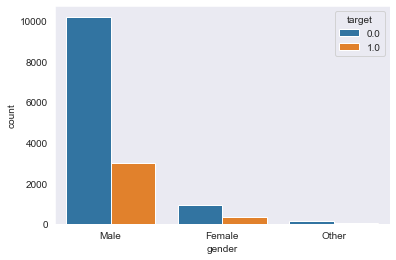

In [111]:
sns.countplot('gender',data=df, hue='target')

In [125]:
total_male0 = df[(df['gender'] == 'Male') & (df['target'] == 0.0)]['gender'].value_counts().sum()
total_male1 = df[(df['gender'] == 'Male') & (df['target'] == 1.0)]['gender'].value_counts().sum()

In [126]:
male_looking_percent = total_male1 / (total_male0 + total_male1) * 100

In [127]:
male_looking_percent

22.781937826185615

In [128]:
total_female0 = df[(df['gender'] == 'Female') & (df['target'] == 0.0)]['gender'].value_counts().sum()
total_female1 = df[(df['gender'] == 'Female') & (df['target'] == 1.0)]['gender'].value_counts().sum()

In [129]:
female_looking_percent = total_female1 / (total_female0 + total_female1) * 100

In [130]:
female_looking_percent

26.33279483037157

- Berdasarkan persentase-nya, perempuan cenderung lebih tinggi kemungkinan-nya untuk mencari pekerjaan, walaupun tidak terlalu beda jauh, (26.33 % untuk perempuan dan 22.78% untuk laki-laki) namun karena mayoritas data adalah laki-laki, jumlah laki-laki yang mencari pekerjaan lebih banyak daripada perempuan.


- Perusahaan harus mengecek lebih lanjut terhadap data perempuan. 

### Analisa Relevant Experience

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='relevent_experience', ylabel='count'>

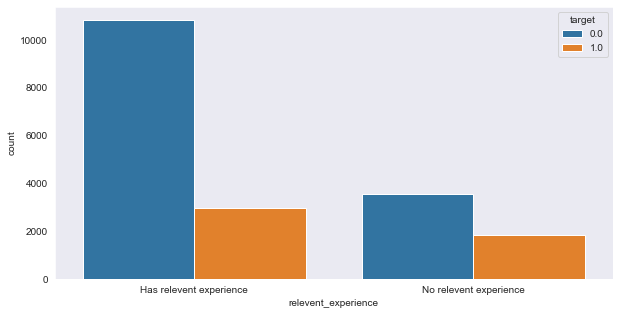

In [131]:
plt.figure(figsize=(10, 5))
sns.countplot('relevent_experience',data=df, hue='target')

- Jumlah orang yang sedang mencari pekerjaan dan memiliki pengalaman yang relevan lebih tinggi dari jumlah orang yang sedang mencari pekerjaan namun tidak memiliki pengalaman yang relevan.


- Namun terlihat bahwa orang yang tidak memiliki pengalaman yang relevan, cenderung sedang mencari pekerjaan.


- Maka dari itu, perusahaan juga harus melihat orang-orang yang tidak memiliki pengalaman yang relevan.

### Analisa Enrolled University

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='enrolled_university', ylabel='count'>

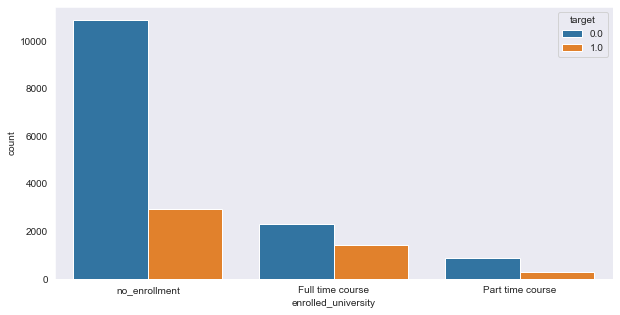

In [132]:
plt.figure(figsize=(10, 5))
sns.countplot('enrolled_university',data=df, hue='target')

- Dari data ini, yang paling banyak mencari pekerjaan adalah orang-orang yang tidak berkuliah no_enrollment.


- Namun dari total data orang yang sedang enrolled university, terlihat bahwa orang yang sedang full time enrolled di universitas memiliki kecenderungan paling tinggi untuk sedang mencari pekerjaan.

### Analisa Education Level

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='education_level', ylabel='count'>

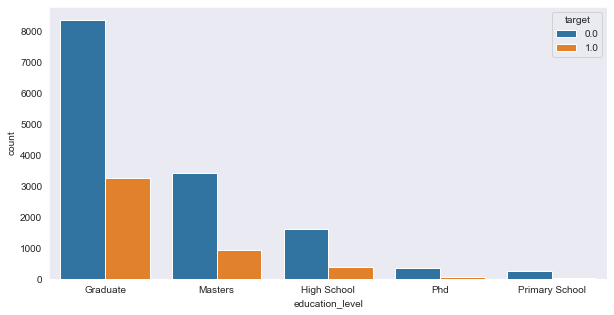

In [13]:
plt.figure(figsize=(10, 5))
sns.countplot('education_level',data=df, hue='target')

In [82]:
total = df[df['target'] == 1.0]['education_level'].value_counts().sum()
total_all = df['education_level'].value_counts().sum()
df[df['target'] == 1.0]['education_level'].value_counts()

Graduate          3245
Masters            935
High School        394
Phd                 58
Primary School      41
Name: education_level, dtype: int64

In [83]:
df[df['target'] == 1.0]['education_level'].value_counts() / total * 100

Graduate          69.441472
Masters           20.008560
High School        8.431415
Phd                1.241173
Primary School     0.877381
Name: education_level, dtype: float64

In [84]:
df[df['target'] == 1.0]['education_level'].value_counts() / total_all * 100

Graduate          17.354797
Masters            5.000535
High School        2.107177
Phd                0.310194
Primary School     0.219275
Name: education_level, dtype: float64

- Graduate dan Masters menempati jumlah tertinggi untuk orang-orang yang sedang mencari pekerjaan (Looking), maka dari itu perusahaan harus cenderung melihat lulusan Graduate dan Masters. 


- Dari total data kandidat yang sedang mencari pekerjaan (Looking), 69% Graduate sedang mencari pekerjaan, 20% Masters sedang mencari pekerjaan, dan 20% high school sedang mencari pekerjaan.


- Dari total data seluruh kandidat, 17% Graduate sedang mencari pekerjaan, 5% Masters sedang mencari pekerjaan, dan 2% high school sedang mencari pekerjaan.


- Perusahaan harus melihat orang-orang yang lulusan Graduate, Masters dan High School

### Analisa Major

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='major_discipline', ylabel='count'>

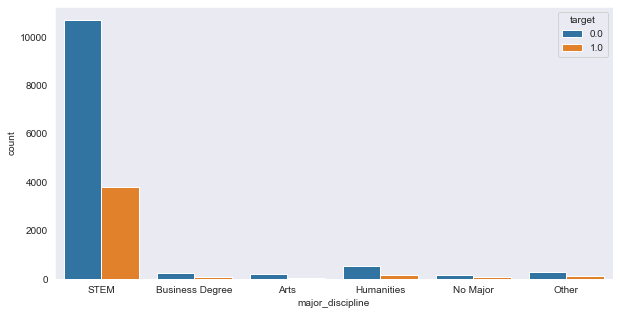

In [14]:
plt.figure(figsize=(10, 5))
sns.countplot('major_discipline',data=df, hue='target')

- Dapat dilihat bahwa orang-orang yang sedang mencari pekerjaan mayoritas adalah STEM. 


- Perusahan harus lebih melihat kandidat dengan jurusan STEM.

### Analisa Experience

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='experience', ylabel='count'>

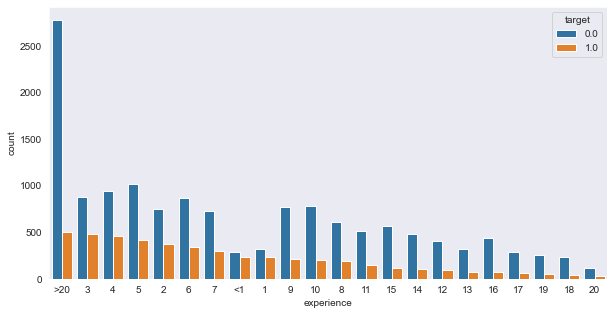

In [42]:
plt.figure(figsize=(10, 5))
sns.countplot('experience',data=df, hue='target', order = df[df['target'] == 1.0]['experience'].value_counts().sort_values(ascending=False).index)

- Untuk yang sedang mencari pekerjaan, mayoritas adalah orang-orang yang memiliki pengalaman di atas 20 tahun


- Namun, perusahaan juga tidak bisa mengabaikan orang-orang yang memiliki pengalaman kerja 2 hingga 5 tahun, karena itu merupakan top 5 dari jumlah-nya jika digrup-kan per-tahun setelah lebih dari 20 tahun.


- Untuk efisiensi, perusahaan bisa melihat orang-orang yang bekerja lebih dari 20 tahun dan juga orang-orang yang memiliki pengalaman kerja 2 hingga 7 tahun.

### Analisa Company Size

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='company_size', ylabel='count'>

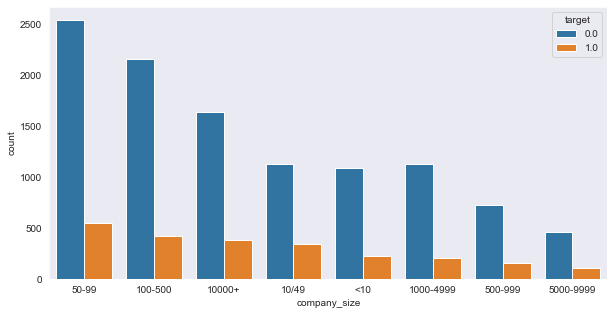

In [45]:
plt.figure(figsize=(10, 5))
sns.countplot('company_size',data=df, hue='target', order = df[df['target'] == 1.0]['company_size'].value_counts().sort_values(ascending=False).index)

In [46]:
df[df['target'] == 1.0]['company_size'].value_counts().sort_values(ascending=False)

50-99        545
100-500      415
10000+       385
10/49        344
<10          224
1000-4999    200
500-999      152
5000-9999    102
Name: company_size, dtype: int64

In [57]:
total = df[df['target'] == 1.0]['company_size'].value_counts().sort_values(ascending=False).sum()
df[df['target'] == 1.0]['company_size'].value_counts().sort_values(ascending=False) / total * 100

50-99        23.024926
100-500      17.532742
10000+       16.265315
10/49        14.533164
<10           9.463456
1000-4999     8.449514
500-999       6.421631
5000-9999     4.309252
Name: company_size, dtype: float64

- Top 5 Kandidat yang mencari pekerjaan adalah kandidat yang memiliki perusahaan sebesar 50-99, 100-500, 10000+, 10-49, dan kurang dari 10.


- Mayoritas kandidat yang mencari pekerjaan adalah yang perusahaan-nya cenderung kecil (50-99, 100-500, 10-49, <10, atau sangat besar (10000+)


- Perusahaan harus melihat orang-orang yang memiliki perusahaan yang cenderung kecil dan sangat besar karena mereka adlah yang cenderung untuk mencari pekerjaan.

### Analisa Company Type

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='company_type', ylabel='count'>

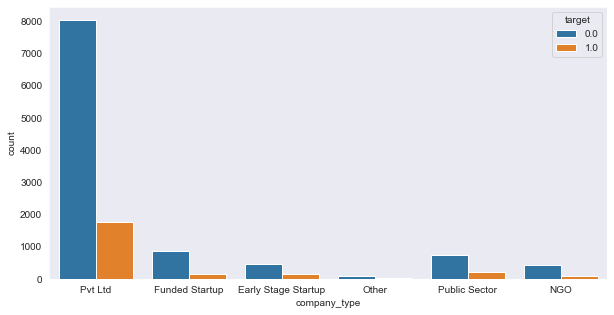

In [60]:
plt.figure(figsize=(10, 5))
sns.countplot('company_type',data=df, hue='target')

- Mayoritas perusahaan yang orang-orang-nya mencari pekerjaan adalah Pvt Ltd. Perusahaan harus melihat perusahaan tersebut dibandingkan dengan perusahaan-perusahaan lain-nya.

### Analisa Last New Job

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='last_new_job', ylabel='count'>

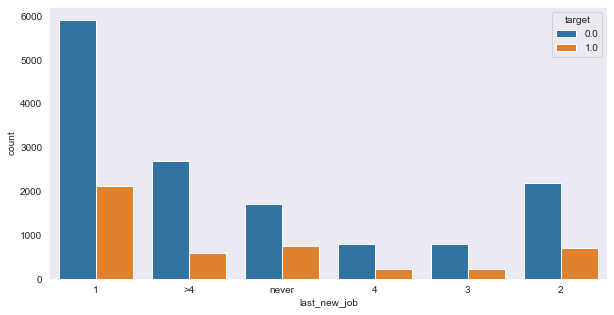

In [61]:
plt.figure(figsize=(10, 5))
sns.countplot('last_new_job',data=df, hue='target')

- Perbedaan tahun antara pekerjaan terakhir-nya dan sekarang untuk orang-orang yang mencari pekerjaan mayoritas adalah satu tahun, diikuti dengan 2 tahun dan tidak pernah memiliki pekerjaan yang jumlah-nya hampir sama.


- Perusahaan harus melihat orang-orang yang waktu menganggur-nya sedikit (1-2 tahun) karena mereka yang lebih banyak yang sedang mencari pekerjaan.


- Selain yang orang-orang yang menganggur-nya sedikit perusahaan juga harus melihat orang-orang yang belum pernah memiliki perkerjaan karena mereka yang cenderung sedang mencari pekerjaan.

### Analisa Training Hours

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


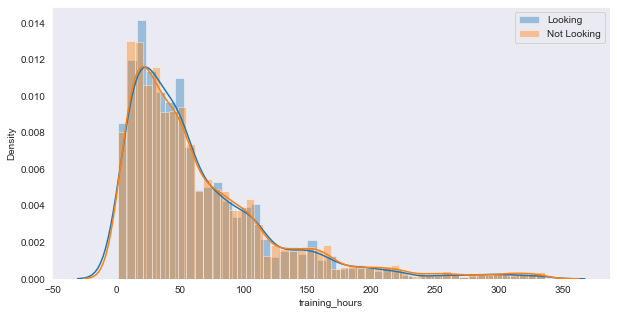

In [69]:
plt.figure(figsize=(10, 5))
sns.distplot(df[df['target'] == 1.0]['training_hours'], label='Looking')
sns.distplot(df[df['target'] == 0.0]['training_hours'], label='Not Looking')
plt.legend()

- Distribusi dari training_hours cenderung right skewed. Tidak ada perbedaan jam untuk orang yang sedang mencari pekerjaan (Looking) dan orang yang tidak sedang mencari pekerjaan (Not Looking). Maka dari itu training_hours tidak dimasukkan ke dalam fitur.